### Summary

Budgets for schools and school districts are huge, complex, and unwieldy. It's no easy task to digest where and how schools are using their resources. Education Resource Strategies is a non-profit that tackles just this task with the goal of letting districts be smarter, more strategic, and more effective in their spending.

Your task is a multi-class-multi-label classification problem with the goal of attaching canonical labels to the freeform text in budget line items. These labels let ERS understand how schools are spending money and tailor their strategy recommendations to improve outcomes for students, teachers, and administrators.

### Problem :

Goal is to predict the probability that a certain label is attached to a budget line item.

Goal is to predict the probability that a certain label is attached to a budget line item.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Ignore deprecation warnings in scikit learn
import warnings
warnings.filterwarnings("ignore")

#### Load Data

In [3]:
# Load Training Data
budget = pd.read_csv('dataset/TrainingData.csv', index_col = 0)

In [ ]:
# Names of columns
budget.columns

##### Exploratory Data Analysis

In [ ]:
# Summary of data
budget.info()

In [ ]:
# Statistical Summary of Data
budget.describe()

In [ ]:
# Count the Data types present in data
budget.dtypes.value_counts()

Labels are of object data type which is generic type of string in python. Working with strings is computatioanlly expensive and scikit learn works with numeric data, so, we need to convert object data type into category data type. After converting to categorical data types, labels are converted into numerical datatypes using pandas.

In [4]:
# Separating labels from other features
labels = ['Function','Object_Type','Operating_Status','Position_Type','Pre_K', 'Reporting',
                'Sharing','Student_Type', 'Use']
features = [c for c in budget.columns if c not in labels]

In [5]:
# astype method works on series but we have a subset of budget dataframe which is also a data frame 
# so use apply method and lambda
categorize_label = lambda x: x.astype('category')
budget[labels] = budget[labels].apply(categorize_label, axis = 0)
budget[labels].dtypes

Function            category
Object_Type         category
Operating_Status    category
Position_Type       category
Pre_K               category
Reporting           category
Sharing             category
Student_Type        category
Use                 category
dtype: object

Now we have 9 broad columns of labels and each column have different sub-labels. So, count the number of sub-labels in each label.

In [10]:
# Calculate number of unique values for each label: num_unique_labels
num_unique_labels = budget[labels].apply(pd.Series.nunique)
num_unique_labels.sum()

104

So, I have total 104 labels which are divided in 9 classes(labels)

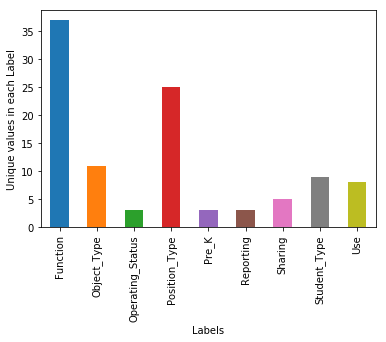

In [11]:
# Plot number of unique values for each label
num_unique_labels.plot(kind = 'bar')
plt.xlabel('Labels')
plt.ylabel('Unique values in each Label')
plt.show()

#### Build a simple Model using only numerical data

Its good to start with simple model using only numerical data. We can get an idea about problem and some processing clues also.

In [6]:
Numerical_label = ['FTE', 'Total']
numerical_data = budget[Numerical_label].fillna(-1000)
labels_to_use = pd.get_dummies(budget[labels])
# note first converted labels from string to category and now from category to binary(numerical form)

###### Split Data 

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
import Multilabel_train_test_split as mlt

# Split and select numeric data only, no nans 
X_train, X_test, y_train, y_test = mlt.multilabel_train_test_split(numerical_data, labels_to_use, size = 0.2, seed = 123)

# Print the info
print("X_train info:")
print(X_train.info())
print("\nX_test info:")  
print(X_test.info())
print("\ny_train info:")  
print(y_train.info())
print("\ny_test info:")  
print(y_test.info()) 

X_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 134338 to 415831
Data columns (total 2 columns):
FTE      320222 non-null float64
Total    320222 non-null float64
dtypes: float64(2)
memory usage: 7.3 MB
None

X_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 206341 to 413949
Data columns (total 2 columns):
FTE      80055 non-null float64
Total    80055 non-null float64
dtypes: float64(2)
memory usage: 1.8 MB
None

y_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 320222 entries, 134338 to 415831
Columns: 104 entries, Function_Aides Compensation to Use_Untracked Budget Set-Aside
dtypes: uint8(104)
memory usage: 34.2 MB
None

y_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 80055 entries, 206341 to 413949
Columns: 104 entries, Function_Aides Compensation to Use_Untracked Budget Set-Aside
dtypes: uint8(104)
memory usage: 8.6 MB
None


###### Train the classifier using training data

In [ ]:
%%time

# Instantiate the classifier: clf
clf = OneVsRestClassifier(LogisticRegression())

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Print the accuracy
print("Accuracy: {}".format(clf.score(X_test, y_test)))

Accuracy is zero but most of the data is not used yet.

The above model is a very basic model and I used only numeric data which constitutes two columns out of 16 features columns. The 14 features columns are text based, and those columns need to be processed before feeding into the scikit learn classifier. Here, comes the NLP(Natural Language Processing) in picture.

#### Representing text numerically

##### 1. Bag - of - words

Bag of words is a simple method to represent text in machine learning. It tokenize the string/document and computes word count or frequency of words in the string/document. Bag of words doesn't care about the grammer and order of words. 

#### 2. CountVectorizer()

This is a Scikit Learn tool to tokenize text data. It performs three main actions.
1. It takes a string and tokenize it according to a given string pattern.
2. It build a vocabulary out of the words taken from the string.
3. It computes the word count of each word in the string.
But CountVectorizer() takes only a single string per row.
Data has 14 features columns that are text based.
To use CountVectorizer(), I need to combine the text of 14 columns in a string per row.

In [13]:
# Combine Text columns for Tokenization
def combine_text_column(df, to_drop = Numerical_label + labels):
    """ converts text in each row of df to single vector """
    
    # Drop non-text columns that are in the df
    to_drop = set(to_drop) & set(df.columns.tolist())
    text_data = df.drop(to_drop, axis = 1)
    
    # Replace nans with blanks
    text_data.fillna('', inplace = True)
    
    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)
    

In [14]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Imputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from metrics import multi_multi_log_loss
from sklearn.metrics.scorer import make_scorer

log_loss_scorer = make_scorer(multi_multi_log_loss)

In [15]:
#Split data and make different pipelines for numerical as well as text pipeline

get_text_data = FunctionTransformer(combine_text_column, validate = False)

get_numerical_data = FunctionTransformer(lambda x: x[Numerical_label], validate = False)

# pipeline for FeatureUnion
numeric_pipeline = Pipeline([('selector',get_numerical_data),
                             ('imputer', Imputer())
                            ])
text_pipeline = Pipeline([('selector', get_text_data),
                          ('vec',CountVectorizer())
                         ])

union = FeatureUnion([('numeric',numeric_pipeline),
                      ('text', text_pipeline)
                     ])


In [ ]:
# train logistic classifier

# Main pipeline to combine all pipelines


pl = Pipeline([('union', FeatureUnion([
                    ('numeric', numeric_pipeline),
                    ('text', text_pipeline)
                ])),
               ('clf', OneVsRestClassifier(LogisticRegression()))
              ])
        
pl.fit(X_train, y_train)

logistic_score = log_loss_scorer(pl, X_test, y_test.values)
logistic_score

In [21]:
# make predictions on hold out data and save in a file
hold_out = pd.read_csv('dataset/TestData.csv', index_col = 0)
predictions = pl.predict_proba(hold_out)
prediction_df = pd.DataFrame(columns = pd.get_dummies(budget[labels], prefix_sep = '__').columns, index = hold_out.index,
                             data = predictions)
prediction_df.to_csv('predictions_logistic.csv')


In [16]:
# Train data using different classifier i.e. RandomForestClassifier

# %%time

pl_1 = Pipeline([('union', FeatureUnion([
                    ('numeric', numeric_pipeline),
                    ('text', text_pipeline)
                ])),
               ('clf', OneVsRestClassifier(RandomForestClassifier()))
              ])
        
pl_1.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('numeric', Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False,
          func=<function <lambda> at 0x000000F0044F9D90>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecat... oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          n_jobs=1))])

In [17]:
random_classifier_10_score = log_loss_scorer(pl_1, X_test, y_test.values)
random_classifier_10_score

0.594186126780781

#### Make Predictions using hold out data

In [18]:
hold_out = pd.read_csv('dataset/TestData.csv', index_col = 0)

predictions = pl_1.predict_proba(hold_out)

prediction_df = pd.DataFrame(columns = pd.get_dummies(budget[labels], prefix_sep = '__').columns, index = hold_out.index,
                             data = predictions)
prediction_df.to_csv('randomclassifier10.csv')